In [328]:
import hnswlib
import numpy as np
import pickle
import numpy as np 
from matplotlib import pyplot as plt 

In [155]:
dim = 1
num_elements = 1000

In [156]:
def create_100_data_points_around(num):
    data = [[x] for x in range(num-50, num+50)]
    labels = [x for x in range(num-50, num+50)]
    return data, labels

In [157]:

# Declaring index
p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 3, M = 3)


In [88]:
# p.add_items(*create_100_data_points_around(100))
# p.add_items(*create_100_data_points_around(1000))
# p.add_items(*create_100_data_points_around(300))
# p.add_items(*create_100_data_points_around(800))
# p.add_items(*create_100_data_points_around(400))
# p.add_items(*create_100_data_points_around(700))
# p.add_items([[500], [501], [599], [600]], [500, 501, 599, 600])

p.add_items(*create_100_data_points_around(50))
p.add_items(*create_100_data_points_around(250))
p.add_items([[110], [190]], [110, 190])
p.add_items([[120], [180]], [120, 180])
p.add_items([[130], [170]], [130, 170])
p.add_items([[140], [160]], [140, 160])
p.add_items([[145], [155]], [145, 155])


In [89]:
labels, distances = p.knn_query([145], k = 10)

In [90]:
print(labels)

[[145 140 130 120 110  99  98  97  96  95]]


In [74]:
print(distances)

[[  0.  25. 100. 225. 225.]]


## Test on MNIST dataset

In [94]:
import h5py

In [142]:
f = h5py.File('mnist-784-euclidean.hdf5', 'r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']

In [348]:
all_data = np.concatenate((train, test))

In [251]:
dim = 784
num_elements = 70000
# Declaring index
p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 5, M = 10)
k = 5

In [252]:
p.add_items(train)

In [253]:
labels, distances = p.knn_query(test[0], k = k)

In [254]:
## retrieve top k index using kNN
def kNN(data, query, k):
    distance = np.sum((data-query)**2, axis=1)
    dist_ind = distance.argsort()[:k]
    return dist_ind

In [255]:
dist_ind = kNN(train, test[0], 5)

In [305]:
def get_recall(retrieved, ground_truth):
    assert(retrieved.shape == ground_truth.shape)
    return np.sum(np.isin(retrieved, ground_truth))/ground_truth.shape[0]

In [290]:
print(get_recall(labels[0], dist_ind))

3


In [364]:
def experiment(init_data, input_data, step, test_k, k):

    dim = 784
    num_elements = 70000
    init_size = init_data.shape[0]

    # Declaring index
    hnsw = hnswlib.Index(space = 'l2', dim = dim)
    
    # Initializing index - the maximum number of elements should be known beforehand
    hnsw.init_index(max_elements = num_elements, ef_construction = 20, M = 50)

    # add init_data
    hnsw.add_items(init_data, np.arange(0, init_size))

    recall_results = []
    # assume hnsw is already initialized and contains an initial distribution
    for x in range(0, input_data.shape[0], step):
        print("Processing:", x)
        # add "step" data points and test on test_k random_data_points
        hnsw.add_items(input_data[x:x+step], np.arange(x+init_size, x+step+init_size))
        step_result = []

        for i in range(test_k):
            # random_test = np.random.choice(256, 784)
            # ground_truth = kNN(np.concatenate((init_data, input_data[:x+step])), random_test, k)
            # retrieved, _ = p.knn_query(random_test, k = k)
            ground_truth = kNN(np.concatenate((init_data, input_data[:x+step])), input_data[x+i], k)
            retrieved, _ = p.knn_query(input_data[x+i], k = k)
            recall = get_recall(retrieved[0], ground_truth)
            step_result.append(recall)
            print(retrieved[0], ground_truth, recall)
        recall_results.append(step_result)
    return recall_results

In [ ]:
cut = 20000
recall_results = experiment(all_data[:cut], all_data[cut:], 100, 5, 10)

In [368]:
avg = np.average(recall_results, axis=1)
print(avg.shape)

(500,)


In [375]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

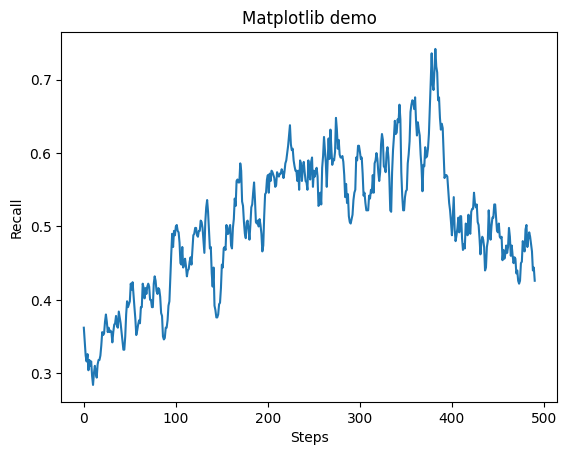

In [377]:
plt.title("Matplotlib demo") 
plt.xlabel("Steps") 
plt.ylabel("Recall") 
plt.plot(moving_average(avg, 10)) 
plt.show()

In [372]:
dim = 784
num_elements = 70000
k = 5
init_size = all_data.shape[0]

# Declaring index
hnsw = hnswlib.Index(space = 'l2', dim = dim)

# Initializing index - the maximum number of elements should be known beforehand
hnsw.init_index(max_elements = num_elements, ef_construction = 20, M = 50)

# add init_data
hnsw.add_items(all_data, np.arange(0, init_size))

step_result = []
x=49900

for i in range(5):
    ground_truth = kNN(all_data, all_data[x+i], k)
    retrieved, _ = p.knn_query(all_data[x+i], k = k)
    recall = get_recall(retrieved[0], ground_truth)
    step_result.append(recall)
    print(retrieved[0], ground_truth, recall)
print(step_result)

[49900 48340 46558  1694 23622] [49900 48340 46558  1694 23622] 1.0
[49901 51907  7115 58552 39922] [49901 51907 68566  7115 58552] 0.8
[49902 34402 37482  7658 58161] [49902 25948 12166 24070 18768] 0.2
[49903 39564 50825 56940 32526] [49903 39564 50825 56940 64473] 0.8
[49904 33900 52923 30537 37076] [49904 41528 33900 63711 52923] 0.6
[1.0, 0.8, 0.2, 0.8, 0.6]


In [373]:
print(avg[-1])

0.5


In [374]:
print(np.average(step_result))

0.6799999999999999
